In [1]:
__author__ = "konwar.m"
__copyright__ = "Copyright 2022, AI R&D"
__credits__ = ["konwar.m"]
__license__ = "Individual Ownership"
__version__ = "1.0.1"
__maintainer__ = "konwar.m"
__email__ = "rickykonwar@gmail.com"
__status__ = "Development"

### Importing Libraries

In [2]:
import os
import copy
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm

from numpy import sqrt 
from sklearn.metrics import mean_squared_error

c:\Users\manash.jyoti.konwar\Documents\AI_Random_Projects\virtualEnvs\MLPricingVenv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
os.chdir('..')
os.getcwd()

'c:\\Users\\manash.jyoti.konwar\\Documents\\AI_Random_Projects\\ML-Retail-Sales'

### Loading Training Data and Features

In [4]:
finalized_train_dict, finalized_test_dict = {}, {}

In [5]:
train_test_path = r'datasets\train_test_datasets_v02'
files = os.listdir(train_test_path)

training_files = [i for i in files if i.endswith('.csv') and i.startswith('train')]
testing_files = [i for i in files if i.endswith('.csv') and i.startswith('test')]

with open(os.path.join('datasets', 'train_test_datasets_v02', 'parent_cat_map.pkl'), "rb") as fp:
    parent_category_map = pickle.load(fp)

parent_category_inv_map = {v: k for k, v in parent_category_map.items()}

In [6]:
parent_category_inv_map

{0: 'Accessories',
 1: 'Android Games',
 2: 'Books',
 3: 'Cinema',
 4: 'Clean Media (Piece)',
 5: 'Clean Media (Spire)',
 6: 'Delivery Of Goods',
 7: 'Film',
 8: 'Games',
 9: 'Gaming Consoles',
 10: 'Gifts',
 11: 'Mac Games',
 12: 'Music',
 13: 'Pc',
 14: 'Pc Games',
 15: 'Payment Cards (Cinema, Music, Games)',
 16: 'Payment Cards',
 17: 'Power Elements',
 18: 'Programs',
 19: 'Service',
 20: 'Tickets (Digit)',
 21: 'Игры'}

In [7]:
for train_file in tqdm(training_files, desc='Loading training files'):
    finalized_train_dict[parent_category_inv_map.get(int(train_file.split('_')[1]))] = pd.read_csv(os.path.join('datasets','train_test_datasets_v02',train_file))

for test_file in tqdm(testing_files, desc='Loading testing files'):
    finalized_test_dict[parent_category_inv_map.get(int(train_file.split('_')[1]))] = pd.read_csv(os.path.join('datasets','train_test_datasets_v02',test_file))    

Loading testing files: 100%|██████████| 21/21 [00:01<00:00, 16.13it/s]


### Preparing baseline data

In [8]:
def prepare_data(**kwargs):
    train_test_data = kwargs.get('train_test_data')
    baseline_features = kwargs.get('baseline_features')
    group_name, group_id = kwargs.get('group_info').get('group_name'), kwargs.get('group_info').get('group_id')

    # Extracting dynamic price ratio features
    item_category_features = list(train_test_data.columns)[list(train_test_data.columns).index('priceratio_parent_category')+1:]

    # Overall features
    baseline_features = baseline_features[:-1] + item_category_features + [baseline_features[-1]]

    # For training: rows having date_block_num from 0 to 31 is utilized for training the model
    train_time_range_lo = (train_test_data['date_block_num'] >= 0)
    train_time_range_hi =  (train_test_data['date_block_num'] <= 32)

    # For validation: rows having date_block_num as 33
    validation_time =  (train_test_data['date_block_num'] == 33)

    # Retrieve rows for train set, val set, test set
    cv_trainset = train_test_data[train_time_range_lo & train_time_range_hi]
    cv_valset = train_test_data[validation_time]
    cv_trainset = cv_trainset[baseline_features]
    cv_valset = cv_valset[baseline_features]

    print('Extracting training data started')
    # Prepare numpy arrays for training/val/test
    cv_trainset_vals = cv_trainset.values.astype(int)
    trainx = cv_trainset_vals[:, 0:len(baseline_features) - 1]
    trainy = cv_trainset_vals[:, len(baseline_features) - 1]
    print('Extracting training data ended')

    print('Extracting validation data started')
    cv_valset_vals = cv_valset.values.astype(int)
    valx = cv_valset_vals[:, 0:len(baseline_features) - 1]
    valy = cv_valset_vals[:, len(baseline_features) - 1]
    print('Extracting validation data ended')

    print('Extracting features dataframe started')
    df_features = pd.DataFrame(baseline_features[:-1], columns=['feature_name'])
    df_features['group_name'] = group_name
    df_features['group_id'] = group_id
    print('Extracting features dataframe ended')

    return trainx, trainy, valx, valy, df_features

In [9]:
baseline_features = ['date_block_num', 'item_id', 'shop_id', 'item_price', 'item_category_id', 
    'count_item_week_shop', 'price_mean_week_category', 'price_lag_item_1', 'price_lag_item_4', 'price_lag_item_12', 
    'price_lag_item_24', 'price_lag_item_shop_1', 'price_lag_item_shop_4', 'price_lag_item_shop_12', 'price_lag_item_shop_24', 
    'week_block_num', 'month', 'seasonal_index', 'priceratio_parent_category', 'item_cnt_day']

finalized_modelling_dict = {}

for parent_cat in finalized_train_dict.keys():
    print(parent_cat)

    train_x_w_price, train_y_w_price, val_x_w_price, val_y_w_price, df_features = prepare_data(
                                                                                    train_test_data=finalized_train_dict.get(parent_cat),
                                                                                    baseline_features=baseline_features,
                                                                                    group_info={'group_name':parent_cat, 'group_id':parent_category_map.get(parent_cat)},
                                                                                )
    if parent_cat not in finalized_modelling_dict.keys():
        finalized_modelling_dict[parent_cat] = {
                                                'train_x': train_x_w_price,
                                                'train_y': train_y_w_price,
                                                'val_x': val_x_w_price,
                                                'val_y': val_y_w_price,
                                                'features_df': df_features
                                            }
    print(train_x_w_price.shape, train_y_w_price.shape, val_x_w_price.shape, val_y_w_price.shape, df_features.shape)

Accessories
Extracting training data started
Extracting training data ended
Extracting validation data started
Extracting validation data ended
Extracting features dataframe started
Extracting features dataframe ended
(43576, 24) (43576,) (1121, 24) (1121,) (24, 3)
Gifts
Extracting training data started
Extracting training data ended
Extracting validation data started
Extracting validation data ended
Extracting features dataframe started
Extracting features dataframe ended
(155946, 26) (155946,) (5268, 26) (5268,) (26, 3)
Mac Games
Extracting training data started
Extracting training data ended
Extracting validation data started
Extracting validation data ended
Extracting features dataframe started
Extracting features dataframe ended
(7, 20) (7,) (1, 20) (1,) (20, 3)
Music
Extracting training data started
Extracting training data ended
Extracting validation data started
Extracting validation data ended
Extracting features dataframe started
Extracting features dataframe ended
(368381, 2

### Extracting features dataframe

#### Forming base features dataframe

In [10]:
df_features = pd.DataFrame()

if len(finalized_modelling_dict.keys())>0:
    for parent_cat in tqdm(finalized_modelling_dict.keys(), desc='Generating features dataframe'):
        df_features =  finalized_modelling_dict.get(parent_cat).get('features_df') if df_features.shape[0] == 0 else pd.concat([df_features, finalized_modelling_dict.get(parent_cat).get('features_df')], ignore_index=True).reset_index(drop=True)

df_features

Generating features dataframe: 100%|██████████| 21/21 [00:00<00:00, 1615.06it/s]


,feature_name,group_name,group_id
0,date_block_num,Accessories,0
1,item_id,Accessories,0
2,shop_id,Accessories,0
3,item_price,Accessories,0
4,item_category_id,Accessories,0
...,...,...,...
469,priceratio_item_category_39,Gaming Consoles,9
470,priceratio_item_category_40,Gaming Consoles,9
471,priceratio_item_category_41,Gaming Consoles,9
472,priceratio_item_category_42,Gaming Consoles,9


#### Adding feature types

In [11]:
df_features = df_features.drop(columns=['feature_type']) if 'feature_type' in df_features.columns else df_features
df_features['feature_type'] = np.nan

for row_index, row_data in df_features.copy().iterrows():
    feature_list = row_data.feature_name.split('_') 
    
    feature_type = 'generic'
    if 'id' in feature_list:
        feature_type = 'id'
    elif 'price' in feature_list and 'lag' in feature_list:
        feature_type = 'lag price'
    elif 'price' in feature_list:
        feature_type = 'price'
    elif 'priceratio' in feature_list:
        feature_type = 'price ratio'
    elif 'seasonal' in feature_list:
        feature_type = 'seasonality'
    
    df_features.iloc[row_index, df_features.columns.get_loc('feature_type')] = feature_type

df_features

,feature_name,group_name,group_id,feature_type
0,date_block_num,Accessories,0,generic
1,item_id,Accessories,0,id
2,shop_id,Accessories,0,id
3,item_price,Accessories,0,price
4,item_category_id,Accessories,0,id
...,...,...,...,...
469,priceratio_item_category_39,Gaming Consoles,9,price ratio
470,priceratio_item_category_40,Gaming Consoles,9,price ratio
471,priceratio_item_category_41,Gaming Consoles,9,price ratio
472,priceratio_item_category_42,Gaming Consoles,9,price ratio


### Extracting xvar dataframe

#### Generating xvar from train data for each parent category

In [12]:
df_xvar = pd.DataFrame(columns=list(df_features.feature_name.unique()))
df_xvar

,date_block_num,item_id,shop_id,item_price,item_category_id,count_item_week_shop,price_mean_week_category,price_lag_item_1,price_lag_item_4,price_lag_item_12,...,priceratio_item_category_34,priceratio_item_category_35,priceratio_item_category_36,priceratio_item_category_37,priceratio_item_category_38,priceratio_item_category_39,priceratio_item_category_40,priceratio_item_category_41,priceratio_item_category_42,priceratio_item_category_43


In [13]:
counter=1
for parent_cat in finalized_train_dict.keys():
    print(parent_cat)
    latest_parent_xvar = finalized_train_dict.get(parent_cat).sort_values('date_block_num').groupby(['shop_id','item_id','item_category_id']).tail(1).reset_index(drop=True)
    print(latest_parent_xvar.shape)
    df_xvar = pd.concat([df_xvar, latest_parent_xvar], ignore_index=True).reset_index(drop=True)
    counter+=1

Accessories
(4788, 27)
Gifts
(27222, 29)
Mac Games
(7, 23)
Music
(78467, 28)
Pc
(3, 23)
Pc Games
(30186, 26)
Payment Cards (Cinema, Music, Games)
(257, 23)
Payment Cards
(964, 26)
Power Elements
(214, 23)
Programs
(6103, 28)
Service
(152, 24)
Android Games
(3, 23)
Tickets (Digit)
(117, 23)
Игры
(3386, 23)
Books
(12024, 34)
Cinema
(129438, 26)
Clean Media (Piece)
(117, 23)
Clean Media (Spire)
(70, 23)
Film
(46402, 23)
Games
(49853, 29)
Gaming Consoles
(4174, 30)


In [14]:
df_xvar

,date_block_num,item_id,shop_id,item_price,item_category_id,count_item_week_shop,price_mean_week_category,price_lag_item_1,price_lag_item_4,price_lag_item_12,...,priceratio_item_category_37,priceratio_item_category_38,priceratio_item_category_39,priceratio_item_category_40,priceratio_item_category_41,priceratio_item_category_42,priceratio_item_category_43,week_start_date,item_cnt_day,parent_category_name
0,0,5588,14,149.0,6,1.0,149.0,149.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-14,1.0,Accessories
1,0,5588,12,149.0,6,2.0,669.5,149.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-14,1.0,Accessories
2,0,5584,7,248.0,6,2.0,423.5,236.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-14,1.0,Accessories
3,0,5601,0,412.0,6,6.0,1056.25,539.1,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-14,1.0,Accessories
4,0,7889,45,12490.0,4,6.0,3751.8,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-14,1.0,Accessories
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393942,33,12118,28,18991.0,42,2.0,20741.0,0.0,22990.0,0.0,...,1.993039,0.622412,NaN,NaN,1.055642,0.831322,NaN,2015-10-05,1.0,Gaming Consoles
393943,33,13407,28,22491.0,42,2.0,20741.0,23641.0,25990.0,27989.75,...,2.360351,0.737122,NaN,NaN,1.250195,0.984533,NaN,2015-10-05,1.0,Gaming Consoles
393944,33,7982,37,21991.0,42,1.0,21991.0,22991.0,25989.666667,25989.875,...,2.307878,0.720735,NaN,NaN,1.222401,0.962646,NaN,2015-10-05,1.0,Gaming Consoles
393945,33,13405,53,20999.0,42,2.0,21699.0,0.0,0.0,0.0,...,2.203771,0.688223,NaN,NaN,1.16726,0.919221,NaN,2015-10-05,1.0,Gaming Consoles


### Data Evaluation

In [15]:
df_exploration_data = finalized_train_dict.get('Accessories').sort_values(by='item_price')
df_exploration_data

,week_start_date,date_block_num,item_id,shop_id,item_price,item_cnt_day,item_category_id,parent_category_name,count_item_week_shop,price_mean_week_category,...,price_lag_item_shop_24,week_block_num,month,seasonal_index,priceratio_parent_category,priceratio_item_category_2,priceratio_item_category_3,priceratio_item_category_4,priceratio_item_category_5,priceratio_item_category_6
15979,2014-02-10,13,5681,22,22.0,1.0,3,Accessories,1.0,22.000000,...,0.0,59,2,1.168464,0.015575,0.013779,0.068490,0.014516,NaN,0.027068
12492,2013-12-16,11,1958,51,27.0,1.0,3,Accessories,1.0,27.000000,...,942.0,51,12,2.512872,0.016243,0.013869,0.073670,0.014058,NaN,0.029790
17500,2014-03-10,14,1958,51,27.0,1.0,3,Accessories,2.0,79.000000,...,0.0,63,3,0.808681,0.019511,0.015613,0.110656,0.018766,NaN,0.039862
18681,2014-04-07,15,1958,26,28.0,1.0,3,Accessories,2.0,163.500000,...,0.0,67,4,0.666544,0.018613,0.015209,0.108562,0.017605,NaN,0.034811
14250,2014-01-06,12,5681,31,28.0,1.0,3,Accessories,3.0,118.333333,...,0.0,54,1,1.107703,0.017617,0.014304,0.077416,0.016270,NaN,0.036242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35139,2015-02-02,25,7935,27,10490.0,1.0,5,Accessories,4.0,5156.666667,...,0.0,110,2,1.168464,4.377637,4.347311,35.083612,4.116796,3.592448,17.811439
35439,2015-02-09,25,7935,38,10490.0,1.0,5,Accessories,1.0,10490.000000,...,0.0,111,2,1.168464,4.071326,4.481077,NaN,4.040125,2.320752,17.947532
34854,2015-01-26,24,7935,27,10490.0,1.0,5,Accessories,9.0,4877.500000,...,249.0,109,1,1.107703,4.114522,4.111326,NaN,4.474961,3.131137,15.462854
35133,2015-02-02,25,7935,19,10490.0,1.0,5,Accessories,1.0,10490.000000,...,0.0,110,2,1.168464,4.377637,4.347311,35.083612,4.116796,3.592448,17.811439


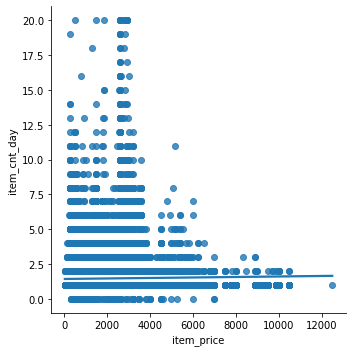

In [16]:
sns.lmplot(x='item_price', y='item_cnt_day', data = df_exploration_data)

### Training XG Boost Regressor

In [17]:
def train_xgboost(**kwargs):
    train_x = kwargs.get('train_x')
    train_y = kwargs.get('train_y')
    val_x = kwargs.get('val_x')
    val_y = kwargs.get('val_y')
    test_x = kwargs.get('test_x') if 'test_x' in kwargs.keys() else pd.DataFrame()
    perform_test_predictions = kwargs.get('perform_test_predictions')

    current = time.time()
    print('Fitting xg boost...')

    model = xgb.XGBRegressor(
                    max_depth = 11, 
                    min_child_weight=0.5, 
                    subsample = 1, 
                    eta = 0.3, 
                    num_round = 1000, 
                    seed = 1, 
                    nthread = 4,
                    verbosity=0)
    model.fit(train_x, train_y, eval_metric='rmse')

    if len(val_x)>0:
        preds = model.predict(val_x)
        # Clipping to range 0-20
        preds = np.clip(preds, 0,20)
        print('val set rmse: ', sqrt(mean_squared_error(val_y, preds)))

        if perform_test_predictions:
            preds = model.predict(test_x)
            # Clipping to range 0-20
            preds = np.clip(preds, 0,20)
            df = pd.DataFrame(preds, columns = ['item_cnt_day'])
            df['ID'] = df.index
            df = df.set_index('ID')
            print('test predictions written to file')
            end = time.time()
            diff = end - current
            print('Took ' + str(int(diff)) + ' seconds to train and predict val, test set')
            return model, df
        else:
            end = time.time()
            diff = end - current
            print('Took ' + str(int(diff)) + ' seconds to train and predict val set')
            return model, pd.DataFrame(columns = ['item_cnt_day'])
    else:
        end = time.time()
        diff = end - current
        print('Took ' + str(int(diff)) + ' seconds to train and predict val set')
        return model, pd.DataFrame(columns = ['item_cnt_day'])

In [18]:
if not os.path.exists(os.path.join('models_outputs', 'models_essentials_v02')):
    os.makedirs(os.path.join('models_outputs', 'models_essentials_v02'))

for parent_cat in tqdm(finalized_modelling_dict.keys(), desc='Training models for parent categories'):

    print('Training, Validating and Saving xg boost model for Category: %s' %(parent_cat))
    
    # Extracting parent category data
    parent_data =  finalized_modelling_dict.get(parent_cat)

    # Training xg boosting model
    model_w_price, test_predictions = train_xgboost(
                                        train_x = parent_data.get('train_x'),
                                        train_y = parent_data.get('train_y'),
                                        val_x = parent_data.get('val_x'),
                                        val_y = parent_data.get('val_y'),
                                        perform_test_predictions = False
                                    )

    # Saving trained model
    model_file_name = 'model_trained_' + str(parent_category_map.get(parent_cat))+ '_w_price.pkl'
    with open(os.path.join('models_outputs', 'models_essentials_v02', model_file_name), 'wb') as model_file:
        pickle.dump(model_w_price, model_file)

Training models for parent categories:   0%|          | 0/21 [00:00<?, ?it/s]

Training, Validating and Saving xg boost model for Category: Accessories
Fitting xg boost...
val set rmse:  1.0141552923663844
Took 9 seconds to train and predict val set


Training models for parent categories:   5%|▍         | 1/21 [00:09<03:12,  9.62s/it]

Training, Validating and Saving xg boost model for Category: Gifts
Fitting xg boost...
val set rmse:  2.6570244343829454
Took 27 seconds to train and predict val set


Training models for parent categories:  14%|█▍        | 3/21 [00:38<03:23, 11.31s/it]

Training, Validating and Saving xg boost model for Category: Mac Games
Fitting xg boost...
val set rmse:  5.960464477539063e-08
Took 0 seconds to train and predict val set
Training, Validating and Saving xg boost model for Category: Music
Fitting xg boost...
val set rmse:  0.42334489062179254
Took 51 seconds to train and predict val set


Training models for parent categories:  24%|██▍       | 5/21 [01:30<04:41, 17.59s/it]

Training, Validating and Saving xg boost model for Category: Pc
Fitting xg boost...
Took 0 seconds to train and predict val set
Training, Validating and Saving xg boost model for Category: Pc Games
Fitting xg boost...
val set rmse:  1.939587823305471
Took 46 seconds to train and predict val set


Training models for parent categories:  29%|██▊       | 6/21 [02:17<06:54, 27.63s/it]

Training, Validating and Saving xg boost model for Category: Payment Cards (Cinema, Music, Games)
Fitting xg boost...
Took 1 seconds to train and predict val set


Training models for parent categories:  33%|███▎      | 7/21 [02:19<04:27, 19.14s/it]

Training, Validating and Saving xg boost model for Category: Payment Cards
Fitting xg boost...
val set rmse:  1.5648047949108026
Took 4 seconds to train and predict val set


Training models for parent categories:  38%|███▊      | 8/21 [02:24<03:10, 14.64s/it]

Training, Validating and Saving xg boost model for Category: Power Elements
Fitting xg boost...
val set rmse:  0.8878515569332921
Took 1 seconds to train and predict val set


Training models for parent categories:  43%|████▎     | 9/21 [02:26<02:08, 10.69s/it]

Training, Validating and Saving xg boost model for Category: Programs
Fitting xg boost...
val set rmse:  1.0194381489691817
Took 11 seconds to train and predict val set


Training models for parent categories:  48%|████▊     | 10/21 [02:38<02:01, 11.04s/it]

Training, Validating and Saving xg boost model for Category: Service
Fitting xg boost...
val set rmse:  1.4807356767461004
Took 1 seconds to train and predict val set


Training models for parent categories:  57%|█████▋    | 12/21 [02:40<00:51,  5.77s/it]

Training, Validating and Saving xg boost model for Category: Android Games
Fitting xg boost...
val set rmse:  1.2535521779486571
Took 0 seconds to train and predict val set
Training, Validating and Saving xg boost model for Category: Tickets (Digit)
Fitting xg boost...


Training models for parent categories:  62%|██████▏   | 13/21 [02:40<00:34,  4.27s/it]

val set rmse:  0.29804858565330505
Took 0 seconds to train and predict val set
Training, Validating and Saving xg boost model for Category: Игры
Fitting xg boost...
val set rmse:  1.8423060742570825
Took 3 seconds to train and predict val set


Training models for parent categories:  67%|██████▋   | 14/21 [02:44<00:28,  4.12s/it]

Training, Validating and Saving xg boost model for Category: Books
Fitting xg boost...
val set rmse:  2.06705434069628
Took 11 seconds to train and predict val set


Training models for parent categories:  71%|███████▏  | 15/21 [02:56<00:38,  6.50s/it]

Training, Validating and Saving xg boost model for Category: Cinema
Fitting xg boost...
val set rmse:  0.6951709779121624
Took 91 seconds to train and predict val set


Training models for parent categories:  76%|███████▌  | 16/21 [04:28<02:41, 32.21s/it]

Training, Validating and Saving xg boost model for Category: Clean Media (Piece)
Fitting xg boost...
Took 2 seconds to train and predict val set


Training models for parent categories:  81%|████████  | 17/21 [04:31<01:33, 23.26s/it]

Training, Validating and Saving xg boost model for Category: Clean Media (Spire)
Fitting xg boost...


Training models for parent categories:  86%|████████▌ | 18/21 [04:31<00:49, 16.45s/it]

Took 0 seconds to train and predict val set
Training, Validating and Saving xg boost model for Category: Film
Fitting xg boost...
val set rmse:  0.930674141422224
Took 27 seconds to train and predict val set


Training models for parent categories:  90%|█████████ | 19/21 [04:59<00:39, 19.82s/it]

Training, Validating and Saving xg boost model for Category: Games
Fitting xg boost...
val set rmse:  2.0052418576982824
Took 64 seconds to train and predict val set


Training models for parent categories:  95%|█████████▌| 20/21 [06:04<00:33, 33.42s/it]

Training, Validating and Saving xg boost model for Category: Gaming Consoles
Fitting xg boost...
val set rmse:  0.4957600601615696
Took 4 seconds to train and predict val set


Training models for parent categories: 100%|██████████| 21/21 [06:09<00:00, 17.58s/it]


### Saving features dataframe

In [19]:
df_features.to_csv(os.path.join('models_outputs', 'models_essentials_v02', 'df_features.csv'), index=False)

### Saving features dataframe

In [20]:
df_xvar.to_csv(os.path.join('models_outputs', 'models_essentials_v02', 'df_xvar.csv'), index=False)